In [3]:
# 向量化（vectorize）

from my_weapon import *
from gensim.models import Word2Vec
import word2vecReader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd, optim

count    2.425314e+06
mean     1.650435e+01
std      5.510423e+00
min      1.000000e+00
25%      1.300000e+01
50%      1.700000e+01
75%      2.000000e+01
max      1.110000e+02
dtype: float64


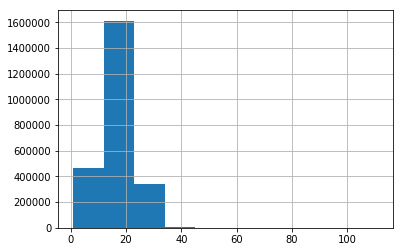

In [78]:
# 统计最长的序列

d = pd.Series([len(line.strip().split(" ")) for line in open("data/train.txt")])
print(d.describe())
d.hist()
plt.show()

In [67]:
wv_model = Word2Vec.load("model/word2vec.mod")

最长的序列是111个tokens，我决定用40作为每个句子的长度

In [70]:
# update vectorize
# 需要经过tweet_process.py的处理

def vectorize(line):
    v = np.zeros(40 * 400).reshape(40, 400)
    words = line.strip().split(" ")
    _index = 0
    for w in words:
        if _index >= 40:
            break
        if w in wv_model.wv:
            v[_index] = wv_model.wv[w]
            _index += 1
    return v

In [71]:
vectorize("what are you doing ?")

array([[-2.08587575,  0.41580471, -2.2741425 , ..., -0.0125636 ,
         2.06250668,  0.08311198],
       [-0.81667441,  0.94962615, -1.45155382, ...,  0.22324868,
         1.16281199, -0.71577537],
       [-0.68626755,  0.78144592, -2.61305523, ...,  0.71367294,
         0.76811117,  2.10258842],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

接下来我们看看另外一个已经训练好的在大的数据集上的word2vec model

location: /media/alex/data/word2vec_twitter_model/

In [72]:
!ls /media/alex/data/word2vec_twitter_model/

README	word2vecReader.py  word2vecReaderUtils.py  word2vec_twitter_model.bin


In [73]:
!cat /media/alex/data/word2vec_twitter_model/README

This zip contains a word2vec model trained on Twitter data as described in:

Godin, F., Vandersmissen, B., De Neve, W., & Van de Walle, R. (2015).
Multimedia Lab @ ACL W-NUT NER shared task: Named entity recognition for Twitter microposts using distributed word representations.
Workshop on Noisy User-generated Text, ACL 2015.

Please cite the paper if you use the model.

This zip contains 2 additional files to read the word2vec model with Python.
The code for this was extracted from the Gensim Library which can be found here: https://radimrehurek.com/gensim/models/word2vec.html
The only difference is that it does not use a strict encoding to read the model from the file.
(One can easily integrate, inherit or extend the library or the Python files)

In [74]:
wv_model2 = word2vecReader.Word2Vec.load_word2vec_format("/media/alex/data/word2vec_twitter_model/word2vec_twitter_model.bin", binary=True)

In [75]:
wv_model2["love"].shape

(400,)

In [78]:
def vectorize_2(line):
    v = np.zeros(40 * 400).reshape(40, 400)
    words = line.strip().split(" ")
    _index = 0
    for w in words:
        if _index >= 40:
            break
        if w in wv_model2:
            v[_index] = wv_model2[w]
            _index += 1
    return v

In [79]:
vectorize_2("i love you so much")

array([[-0.03832966,  0.00200333, -0.04462779, ...,  0.0044597 ,
         0.02114136, -0.02238772],
       [ 0.04128342,  0.07181156,  0.00676483, ..., -0.00052616,
         0.01673744,  0.01691386],
       [-0.01901733,  0.00757742,  0.00171131, ...,  0.05948232,
         0.0217214 , -0.00660098],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [3]:
# batch=10, in_channels=2, height(num of tokens)=20, width(length of word2vec)=400
_in = torch.randn(10, 2, 40, 400)

# in_channels=2, out_channels=32, kernel_size=(3, 400)
tmp_mod = torch.nn.Conv2d(2, 64, kernel_size=(3, 400), groups=2)

_out = tmp_mod(_in)
print("conv1:", _out.size())

_out = F.relu(_out)
print("relu:", _out.size())

_out = torch.squeeze(_out)
print("squeeze:", _out.size())

_out = F.max_pool1d(_out, 2)
print("max_pool1d:", _out.size())

_out = _out.view(-1, 2 * 32 * 19)
print("flat:", _out.size())

f1 = nn.Linear(1216, 64)
_out = f1(_out)
_out = F.relu(_out)
print("f1:", _out.size())

f2 = nn.Linear(64, 32)
_out = f2(_out)
_out = F.relu(_out)
print("f2:", _out.size())

f3 = nn.Linear(32, 1)
_out = f3(_out)
# _out = F.relu(_out)
print("f3:", _out.size())

probs = F.softmax(_out, 1)
print(probs)
torch.max(probs, 1)[1]
    


conv1: torch.Size([10, 64, 38, 1])
relu: torch.Size([10, 64, 38, 1])
squeeze: torch.Size([10, 64, 38])
max_pool1d: torch.Size([10, 64, 19])
flat: torch.Size([10, 1216])
f1: torch.Size([10, 64])
f2: torch.Size([10, 32])
f3: torch.Size([10, 1])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SoftmaxBackward>)


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [2]:
_in = torch.randn(10, 2, 40, 400)
model = CNNClassifier()
model(_in)

NameError: name 'CNNClassifier' is not defined

In [97]:
# make train dataset

import random

with open("data/train_dataset.txt", "w") as f:
    lines = []
    for line in open("data/0-train.txt"):
        lines.append("0\t{}".format(line))
    for line in open("data/1-train.txt"):
        lines.append("1\t{}".format(line))
    random.shuffle(lines)
    
    for line in lines:
        f.write(line)

In [4]:
class Config:
    def __init__(self):
        self.train_file = "data/train_dataset.txt"
        self.train_batch_size = 128
        
        self.learning_rate = 0.001
        self.window_size = 3
        self.num_classes = 2
        
        self.num_epochs = 10
        self.train_steps = None
        
        self.summary_interval = 100
        
config = Config()

In [5]:
def read_wv1():
    print("Loading wv1 ...")
    return Word2Vec.load("model/word2vec.mod")
        
def read_wv2():
    print("Loading wv2 ...")
    return word2vecReader.Word2Vec.load_word2vec_format(
        "/media/alex/data/word2vec_twitter_model/word2vec_twitter_model.bin", binary=True)
    
%time _wv1 = read_wv1()
%time _wv2 = read_wv2()

Loading wv1 ...
CPU times: user 1.28 s, sys: 1.28 s, total: 2.56 s
Wall time: 4.52 s
Loading wv2 ...
CPU times: user 45.9 s, sys: 2.62 s, total: 48.5 s
Wall time: 48.6 s


In [32]:
# cnt = 0

class Dataset:
    def __init__(self, filepath, batch_size):
        self._file = open(filepath)
        self._wv1 = _wv1
        self._wv2 = _wv2
        self._batch_size = batch_size
        self._reset()
        
    def wv1(self, line):
        v = np.zeros(40 * 400).reshape(40, 400)
        words = line.strip().split(" ")
        _index = 0
        for w in words:
            if _index >= 40:
                break
            if w in self._wv1.wv:
                v[_index] = self._wv1.wv[w]
                _index += 1
        return v

    def wv2(self, line):
            v = np.zeros(40 * 400).reshape(40, 400)
            words = line.strip().split(" ")
            _index = 0
            for w in words:
                if _index >= 40:
                    break
                if w in self._wv2:
                    v[_index] = self._wv2[w]
                    _index += 1
            return v

    # 迭代时候每次先调用__iter__，初始化
    # 接着调用__next__返回数据
    # 如果没有buffer的时候，就补充数据_fill_buffer
    # 如果buffer补充后仍然为空，则停止迭代

    def __iter__(self):
        self._reset()
        return self
    
    def _fill_buffer(self, size):
        # global cnt

        if self._buff_count == 0:
            print("buffer空了，补充数据 ...")
            for line in self._file:
                try:
                    label, sentence = line.strip().split("\t")
                except ValueError:
                    continue
                label = int(label.strip())
                sequence1 = self.wv1(sentence)
                sequence2 = self.wv2(sentence)
                self._buff_count += 1
                self._buffer.append((label, [sequence1, sequence2]))
                ## 直到满足size
                
                if self._buff_count >= size:
                    break
                    
                # cnt += 1
                # if cnt % 10000 == 0:
                #    print(cnt)
            self._buffer_iter = iter(self._buffer)
    
    def __next__(self):
        self._fill_buffer(self._batch_size * 1000) # 每次读1024个batch作为buffer
        
        if self._buff_count == 0: # After filling, still empty, stop iter!
            raise StopIteration
                
        # global cnt
        label_batch = []
        sequence_batch = []
        for label, sequence in self._buffer_iter:
            self._buff_count -= 1
            label_batch.append(label)
            sequence_batch.append(sequence)
            if len(label_batch) == self._batch_size:
                break


        return {"sequences": np.array(sequence_batch), "labels": label_batch, }

    def _reset(self):
        self._file.seek(0)
        self._buffer = []
        self._buffer_iter = None
        self._buff_count = 0
        
    def get_testdata(self):
        labels = []
        sequences = []
        for line in open("data/0-test.txt"):
            labels.append(0)
            sequences.append([self.wv1(line), self.wv2(line)])
        for line in open("data/1-test.txt"):
            labels.append(1)
            sequences.append([self.wv1(line), self.wv2(line)])
        return torch.LongTensor(labels), torch.Tensor(sequences)

    
train_set = Dataset(config.train_file, config.train_batch_size)
%time test_labels, test_X = train_set.get_testdata()

CPU times: user 25.4 s, sys: 8 ms, total: 25.4 s
Wall time: 25.4 s


In [26]:
for i, batch in enumerate(train_set):
    if i % 500 == 0:
        sequences = torch.Tensor(batch["sequences"])
        labels = torch.LongTensor(batch["labels"])
        print(i, sequences.size(), labels.size())
        break

buffer空了，补充数据 ...
0 torch.Size([128, 2, 40, 400]) torch.Size([128])


In [20]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()

        # 2 in- channels, 32 out- channels, 3 * 400 windows size
        self.conv = torch.nn.Conv2d(2, 64, kernel_size=(3, 400), groups=2) 
        self.f1 = nn.Linear(1216, 64)
        self.f2 = nn.Linear(64, 32)
        self.f3 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv(x)
        out = F.relu(out)
        out = torch.squeeze(out)
        out = F.max_pool1d(out, 2)
        out = out.view(-1, 2 * 32 * 19) # 9 is after pooling
        out = F.relu(self.f1(out))
        out = F.relu(self.f2(out))
        out = self.f3(out)
        # print(out.size())
        
        probs = F.softmax(out, dim=1)
        # print(probs)
        classes = torch.max(probs, 1)[1]

        return probs, classes
    


In [ ]:
import logging
logging.basicConfig(format="%(levelname)s\t%(asctime)s\t%(message)s", level=logging.INFO)

from tensorboardX import SummaryWriter
from sklearn.metrics import classification_report


def train():

    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    writer = SummaryWriter(log_dir="log")
    
    epoch = 0
    step = 0

    for epoch in range(1, config.num_epochs + 1):
        logging.info("==================== Epoch: {} ====================".format(epoch))
        running_losses = []
        for batch in train_set:

            sequences = torch.Tensor(batch["sequences"])
            labels = torch.LongTensor(batch["labels"])

            # Predict
            try:
                probs, classes = model(sequences)
            except:
                print(sequences.size(), labels.size())
                exit(-1)

            # Backpropagation
            optimizer.zero_grad()
            losses = loss_function(probs, labels)
            losses.backward()
            optimizer.step()

            # Log summary
            running_losses.append(losses.data.item())
            if step % config.summary_interval == 0:
                loss = sum(running_losses) / len(running_losses)
                writer.add_scalar("train/loss", loss, step)
                logging.info("step = {}, loss = {}".format(step, loss))
                running_losses = []
            
            step += 1
        
        # Classification report
        probs, y_pred = model(test_X)
        target_names = ['pro-hillary', 'pro-trump']
        print(classification_report(test_labels, y_pred, target_names=target_names))

        epoch += 1
        
model = CNNClassifier()
train()

INFO	2018-11-26 19:14:19,993	==================== Epoch: 1 ====================


buffer空了，补充数据 ...


INFO	2018-11-26 19:14:29,585	step = 0, loss = 0.7093743681907654
INFO	2018-11-26 19:14:37,474	step = 100, loss = 0.6470441317558289
INFO	2018-11-26 19:14:43,797	step = 200, loss = 0.6051749521493912
INFO	2018-11-26 19:14:50,283	step = 300, loss = 0.5732173711061478
INFO	2018-11-26 19:14:56,350	step = 400, loss = 0.558872994184494
INFO	2018-11-26 19:15:03,328	step = 500, loss = 0.5485111489892006
INFO	2018-11-26 19:15:09,534	step = 600, loss = 0.5401800882816314
INFO	2018-11-26 19:15:16,229	step = 700, loss = 0.5370687690377235
INFO	2018-11-26 19:15:22,392	step = 800, loss = 0.5362289342284202
INFO	2018-11-26 19:15:28,223	step = 900, loss = 0.5305288290977478


buffer空了，补充数据 ...
